In [4]:
%pylab inline
import control
import pyhull
import string
import picos as pic
import cvxopt as cvx
import numpy as np
import scipy.linalg
import scipy.optimize
import scipy.integrate
import itertools
import sympy
import sympy.physics.mechanics as me
from matplotlib.patches import Ellipse

Populating the interactive namespace from numpy and matplotlib


In [158]:
def gam(theta):
    gam = np.array([[cos(theta), -sin(theta), 0],
                    [sin(theta), cos(theta), 0],
                    [0, 0, 1]])
    return gam

In [666]:
def lqg(x0, ut, P0):
    
    u = ut[0,0]
    w = ut[1,0]
    
    H = np.array([[1, 0, 0],
                  [0, 1, 0]])  # measurment matrix 2*3
    # noise variance
    M = np.array([[0.00001, 0.00002],
                  [0.00002, 0.00002]]) # 2*2 
    N = 1*np.eye(2) 
    
    #lq
    A_s = np.array([
    [1, w, 0],
    [-w, 1, u],
    [0, 0, 1]])
    B = np.array([
        [1, 0],
        [0, 0],
        [0, 1]])
    C = H.T @ H
    D = np.eye(2)

    St = scipy.linalg.solve_discrete_are(A_s, B, C, D) # riccati solution
    L = -inv(B.T@St@B+D)@B.T@St@A_s # riccati gain
    
    # initial condition
    P = P0 # covariance
    ut_b = ut
    u_b = u 
    w_b = w
    xs = x0
    xh = xs
    xe = []
    xr = []
    utb = []
    xer = []
    xe_ = []
    
    for i in range(5): # 0<=t<=n
        
        theta = xs[2,0]
        # noise
        m = np.random.normal(0, sqrt(M), (2,1))
        n = np.random.normal(0, sqrt(N), (2,1))
        
        A = np.array([
        [1, w_b, 0],
        [-w_b, 1, u_b],
        [0, 0, 1]])
        
        # Kalman filter
        # process update
        Pp = A@P@A.T+B@M@B.T
        xh_ = A@gam(-xh[2,0])@xh + B@ut_b +B@m
        # acquire z
        z = H@gam(-theta)@xs + n # measurement?

        theta_ = xh_[2,0]
        # measurement update
        Ploc = gam(-theta_)@Pp
        K = Ploc@H.T@inv(H@Ploc@H.T+N)
        Ploc = (np.eye(3)-K@H)@Ploc
        P = inv(gam(-theta_))@Ploc
        R = np.array([[cos(-theta_), -sin(-theta_)],
                    [sin(-theta_), cos(-theta_)]])
        xh = xh_+gam(theta_)@K@R@(z-H@xh_) # x_hat
        xe_.append(xh_)
        xe.append(xh) # estimation 
        
        # input update
        xs = A_s@gam(-theta)@xs + B@ut +B@m
        xr.append(xs)
        theta = xs[2,0]
        ut_b = ut+L@gam(-theta)@(xh-xs)
        xer.append(xh-xs)
        utb.append(ut_b)
        u_b = ut_b[0,0]
        w_b = ut_b[1,0]
    
    return xe, xr, utb, xer, xe_

In [685]:
x0 = array([[1],[1],[0]])
ut = array([[1],[0]])
P0 = array([[1, 0, 0],[0, 1, 0],[0, 0, 1]]) # initial covariance?

xe, xr, utb, xer, xe_= lqg(x0, ut, P0)

In [686]:
xe #estimation

[array([[ 1.3314154 ],
        [ 0.99866215],
        [-0.00366613]]), array([[2.27869939],
        [1.00295187],
        [0.00262126]]), array([[ 3.63848747e+00],
        [ 1.01045806e+00],
        [-3.17164032e-03]]), array([[ 4.45945931],
        [ 1.01376509],
        [-0.00506142]]), array([[ 5.65432430e+00],
        [ 1.02283566e+00],
        [-2.03528632e-04]])]

In [687]:
xr # reference trajectory

[array([[ 2.00399074],
        [ 1.        ],
        [-0.00298376]]), array([[ 3.00270186e+00],
        [ 1.00299120e+00],
        [-2.19114183e-03]]), array([[ 4.00028607e+00],
        [ 1.00737699e+00],
        [-2.07062604e-03]]), array([[ 4.99714935e+00],
        [ 1.01358730e+00],
        [-3.29807445e-03]]), array([[ 5.99368267e+00],
        [ 1.02676465e+00],
        [-2.64326087e-03]])]

In [688]:
xe_ # estimation (propagate)

[array([[ 2.00399074],
        [ 1.        ],
        [-0.00298376]]), array([[ 2.74758775e+00],
        [ 9.95080375e-01],
        [-4.13590372e-04]]), array([[ 3.72335004e+00],
        [ 1.01270645e+00],
        [-2.49068659e-03]]), array([[ 4.85809032e+00],
        [ 1.01718404e+00],
        [-4.14379840e-03]]), array([[ 5.78956189e+00],
        [ 1.01634961e+00],
        [-1.43637608e-03]])]

In [689]:
utb # new input for estimation

[array([[1.4156701 ],
        [0.00245993]]), array([[ 1.44745701],
        [-0.00523246]]), array([[1.22360730e+00],
        [2.55290323e-04]]), array([[1.33230928],
        [0.00297023]]), array([[ 1.20972786e+00],
        [-7.29687476e-04]])]

In [690]:
xer #error

[array([[-0.67257534],
        [-0.00133785],
        [-0.00068238]]), array([[-7.24002470e-01],
        [-3.93331935e-05],
        [ 4.81239778e-03]]), array([[-0.3617986 ],
        [ 0.00308106],
        [-0.00110101]]), array([[-5.37690043e-01],
        [ 1.77787886e-04],
        [-1.76334581e-03]]), array([[-0.33935837],
        [-0.003929  ],
        [ 0.00243973]])]

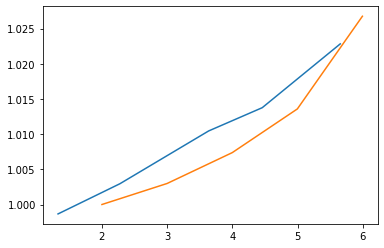

In [691]:
x_est = []
y_est = []
x_ref = []
y_ref = []
for i in range(5):
    x_est.append(xe[i][0][0])
    y_est.append(xe[i][1][0])
    x_ref.append(xr[i][0][0])
    y_ref.append(xr[i][1][0])
    
plt.plot(x_est,y_est)
plt.plot(x_ref,y_ref)

In [692]:
def lqg_turn(x0, ut, P0):
    
    H = np.array([[1, 0, 0],
                  [0, 1, 0]])  # measurment matrix 2*3
    # noise variance
    M = np.array([[1e-5, 2e-5],
                  [2e-5, 2e-5]]) # 2*2 
    N = 1*np.eye(2) 
    
    # initial condition
    P = P0 # covariance   
    u_b = ut[0,0] 
    w_b = ut[1,0]
    ut_b = array([[u_b],[w_b]])
    xs = x0
    theta = xs[2,0]
    xh = xs
    xe = []
    xr = []
    utb = []
    xer = []
    xe_ = []
    Ln = []
    
    for j in range(4):
        u = ut[0,j+1]
        w = ut[1,j+1]
        #lq
        A_s = np.array([
        [1, w, 0],
        [-w, 1, u],
        [0, 0, 1]])
        B = np.array([
            [1, 0],
            [0, 0],
            [0, 1]])
        C = H.T @ H
        D = np.eye(2)

        St = scipy.linalg.solve_discrete_are(A_s, B, C, D) # riccati solution
        L = -inv(B.T@St@B+D)@B.T@St@A_s # riccati gain
        Ln.append(L)
    
    for i in range(5): # 0<=t<=n

        u = ut[0,i]
        w = ut[1,i]
        theta = xs[2,0]
        
        A_s = np.array([
        [1, w, 0],
        [-w, 1, u],
        [0, 0, 1]])
        
        # noise
        m = np.random.normal(0, sqrt(M), (2,1))
        n = np.random.normal(0, sqrt(N), (2,1))
        
        A = np.array([
        [1, w_b, 0],
        [-w_b, 1, u_b],
        [0, 0, 1]])
        
        
        # Kalman filter
        # process update
        Pp = A@P@A.T+B@M@B.T
        xh_ = A@gam(-xh[2,0])@xh + B@ut_b +B@m
        # acquire z
        z = H@gam(-theta)@xs + n # measurement?

        theta_ = xh_[2,0]
        # measurement update
        Ploc = gam(-theta_)@Pp
        K = Ploc@H.T@inv(H@Ploc@H.T+N)
        Ploc = (np.eye(3)-K@H)@Ploc
        P = inv(gam(-theta_))@Ploc
        R = np.array([[cos(-theta_), -sin(-theta_)],
                    [sin(-theta_), cos(-theta_)]])
        xh = xh_+gam(theta_)@K@R@(z-H@xh_) # x_hat
        xe_.append(xh_)
        xe.append(xh) # estimation 
        
        # input update
        theta = xs[2,0]
        xs = A_s@gam(-theta)@xs + B@ut[:,i].reshape(2,1) +B@m
        xr.append(xs)
        if i < 4:
            ut_b = Ln[i]@gam(-theta)@(xh-xs) +ut[:,i].reshape(2,1)
        xer.append(A)
        utb.append(A_s)
        u_b = ut_b[0,0]
        w_b = ut_b[1,0]
    
    return xe, xr, utb, xer, xe_

In [719]:
x0 = array([[1],[1],[0]])
ut = array([[1,1,1,1,1],[0,0,pi/2,0,0]])
P0 = array([[1, 0, 0],[0, 1, 0],[0, 0, 1]]) # initial covariance?

xe, xr, utb, xer, xe_= lqg_turn(x0, ut, P0)

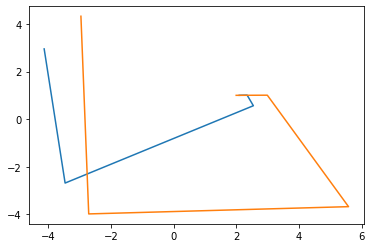

In [720]:
x_est = []
y_est = []
x_ref = []
y_ref = []
for i in range(5):
    x_est.append(xe[i][0][0])
    y_est.append(xe[i][1][0])
    x_ref.append(xr[i][0][0])
    y_ref.append(xr[i][1][0])
    
plt.plot(x_est,y_est)
plt.plot(x_ref,y_ref)

In [683]:
xe # estimation

[array([[1.92309918e+00],
        [1.00001825e+00],
        [3.63594459e-04]]), array([[ 2.65857363],
        [ 0.99839538],
        [-0.00535685]]), array([[3.3594528 ],
        [0.9957202 ],
        [0.00502505]]), array([[4.58477942e+00],
        [1.00144612e+00],
        [3.41424792e-03]]), array([[ 5.76595736e+00],
        [ 1.00585788e+00],
        [-4.36149570e-03]])]

In [684]:
xr #reference

[array([[2.],
        [1.],
        [0.]]), array([[3.],
        [1.],
        [0.]]), array([[4.],
        [1.],
        [0.]]), array([[5.],
        [1.],
        [0.]]), array([[6.],
        [1.],
        [0.]])]

In [546]:
xe_ # estimation (propagate)

[array([[1.99836462e+00],
        [1.00000000e+00],
        [1.11019959e-03]]), array([[2.97225512],
        [1.00181777],
        [0.00350496]]), array([[4.25204821],
        [0.9971319 ],
        [0.00858678]]), array([[-14.55782531],
        [-18.60915434],
        [  5.35111988]]), array([[-47.58402772],
        [ 61.25874811],
        [ -8.83105138]])]

In [586]:
utb

[array([[ 1.,  0.,  0.],
        [-0.,  1.,  1.],
        [ 0.,  0.,  1.]]), array([[ 1.,  0.,  0.],
        [-0.,  1.,  1.],
        [ 0.,  0.,  1.]]), array([[ 1.        ,  3.14159265,  0.        ],
        [-3.14159265,  1.        ,  1.        ],
        [ 0.        ,  0.        ,  1.        ]]), array([[ 1.,  0.,  0.],
        [-0.,  1.,  1.],
        [ 0.,  0.,  1.]]), array([[ 1.,  0.,  0.],
        [-0.,  1.,  1.],
        [ 0.,  0.,  1.]])]

In [587]:
xer

[array([[ 1.,  0.,  0.],
        [-0.,  1.,  1.],
        [ 0.,  0.,  1.]]), array([[ 1.        , -0.0068224 ,  0.        ],
        [ 0.0068224 ,  1.        ,  1.51941425],
        [ 0.        ,  0.        ,  1.        ]]), array([[ 1.        , -0.59111718,  0.        ],
        [ 0.59111718,  1.        ,  1.68907701],
        [ 0.        ,  0.        ,  1.        ]]), array([[ 1.        ,  3.42835558,  0.        ],
        [-3.42835558,  1.        ,  3.34472582],
        [ 0.        ,  0.        ,  1.        ]]), array([[ 1.        , -3.87004134,  0.        ],
        [ 3.87004134,  1.        ,  1.30312677],
        [ 0.        ,  0.        ,  1.        ]])]